In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import sys
sys.path.append('../Src/')
sys.path.append('../')

import os
import argparse
import random
import logging
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path


#from utils import __balance_val_split, __split_of_train_sequence, __log_class_statistics
#from czech_slr_dataset import CzechSLRDataset,GaussianNoise
from Lsp_dataset import LSP_Dataset 
from spoter.gaussian_noise import GaussianNoise
from spoter.utils import my_evaluate
#from spoter_model import SPOTER
#from spoter.utils import train_epoch, evaluate
#from spoter.gaussian_noise import GaussianNoise

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [52]:
class args:
    def __init__(self):
        self.seed = 379
        self.testing_set_path = '../../DATASETS/WLASL--mediapipe-Val.hdf5'
        self.training_set_path = '../../DATASETS/WLASL--mediapipe-Train.hdf5' 
        self.experiment_name = 'cris_wholepose_WLASL_TEST_model2'
        self.keypoints_model = 'wholepose'
        self.checkpoint_name = 'checkpoint_t_0.pth'
        self.gaussian_mean  = 0
        self.gaussian_std  =0.001
                        
args = args()

In [53]:
random.seed(args.seed)
np.random.seed(args.seed)
os.environ["PYTHONHASHSEED"] = str(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.deterministic = True
g = torch.Generator()
g.manual_seed(args.seed)

In [54]:
# Set device to CUDA only if applicable
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [55]:
transform = transforms.Compose([GaussianNoise(args.gaussian_mean, args.gaussian_std)])

train_set = LSP_Dataset(args.training_set_path, args.keypoints_model,transform=transform, augmentations=False,
                        landmarks_ref= '../Data/Mapeo landmarks librerias - Hoja 1_2.csv')
train_loader = DataLoader(train_set, shuffle=True, generator=g)

path                       : ../../DATASETS/WLASL--mediapipe-Train.hdf5
keypoints_model            : wholepose
landmarks_ref              : ../Data/Mapeo landmarks librerias - Hoja 1_2.csv
threshold_frecuency_labels : 0
list_labels_banned         : ['ya', 'qué?', 'qué', 'bien', 'dos', 'ahí', 'luego', 'yo', 'él', 'tú', '???', 'NNN']
Use keypoint model :  wholepose
use column for index keypoint : wp_indexInArray
section_keypoints :  71  -- uniques:  71
name_keypoints    :  71  -- uniques:  51
idx_keypoints     :  71  -- uniques:  71

section_keypoints used:
['pose_nose' 'pose_left_eye' 'pose_right_eye' 'pose_left_shoulder'
 'pose_right_shoulder' 'pose_left_elbow' 'pose_right_elbow'
 'pose_left_wrist' 'pose_right_wrist' 'face_right_mouth_up'
 'face_right_eyebrow_inner' 'face_right_mouth_corner'
 'face_right_eyebrow_outer' 'face_right_mouth_down'
 'face_right_eyebrow_middle' 'face_right_eye_outer' 'face_right_jaw_up'
 'face_right_eye_inner' 'face_right_jaw_down' 'face_right_jaw_middle'
 'f

  8%|███▎                                   | 115/1356 [00:00<00:03, 388.59it/s]

original size video :  (92, 543, 2) -- label :  dark
filtering by keypoints idx .. 
filtered size video :  (92, 71, 2) -- label :  dark


100%|█████████████████████████████████████| 1356/1356 [00:00<00:00, 1425.55it/s]


label encoding ...
sorted(set(labels_dataset))  :  ['accident', 'all', 'apple', 'backpack', 'basketball', 'bed', 'before', 'bird', 'black', 'blue', 'book', 'bowling', 'brown', 'can', 'candy', 'cat', 'change', 'check', 'city', 'color', 'computer', 'cool', 'corn', 'cousin', 'cow', 'dark', 'deaf', 'decide', 'dog', 'drink', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'headache', 'hearing', 'help', 'hot', 'how', 'inform', 'kiss', 'language', 'last', 'later', 'laugh', 'learn', 'like', 'man', 'many', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'secretary', 'shirt', 'short', 'show', 'son', 'study', 'sunday', 'take', 'tall', 'teacher', 'tell', 'thanksgiving', 'thin', 'thursday', 'trade', 'visit', 'wait', 'walk', 'want', 'water', 'what', 'white', 'who', 'wife', 'woman', 'work', 'write', 'wrong', 'year', 'yellow', 'yes', 'yesterday']
dict_labels_dataset      : {'accident': 0, 'all

In [56]:
eval_set = LSP_Dataset(args.testing_set_path,args.keypoints_model,
                     dict_labels_dataset=train_set.dict_labels_dataset,
                     inv_dict_labels_dataset = train_set.inv_dict_labels_dataset,
                        landmarks_ref= '../Data/Mapeo landmarks librerias - Hoja 1_2.csv')
eval_loader = DataLoader(eval_set, shuffle=True, generator=g)

#eval_set = LSP_Dataset(args.testing_set_path,args.keypoints_model, transform=transform, augmentations=False)
#eval_loader = DataLoader(eval_set, shuffle=True, generator=g)

path                       : ../../DATASETS/WLASL--mediapipe-Val.hdf5
keypoints_model            : wholepose
landmarks_ref              : ../Data/Mapeo landmarks librerias - Hoja 1_2.csv
threshold_frecuency_labels : 0
list_labels_banned         : ['ya', 'qué?', 'qué', 'bien', 'dos', 'ahí', 'luego', 'yo', 'él', 'tú', '???', 'NNN']
Use keypoint model :  wholepose
use column for index keypoint : wp_indexInArray
section_keypoints :  71  -- uniques:  71
name_keypoints    :  71  -- uniques:  51
idx_keypoints     :  71  -- uniques:  71

section_keypoints used:
['pose_nose' 'pose_left_eye' 'pose_right_eye' 'pose_left_shoulder'
 'pose_right_shoulder' 'pose_left_elbow' 'pose_right_elbow'
 'pose_left_wrist' 'pose_right_wrist' 'face_right_mouth_up'
 'face_right_eyebrow_inner' 'face_right_mouth_corner'
 'face_right_eyebrow_outer' 'face_right_mouth_down'
 'face_right_eyebrow_middle' 'face_right_eye_outer' 'face_right_jaw_up'
 'face_right_eye_inner' 'face_right_jaw_down' 'face_right_jaw_middle'
 'fac

 30%|████████████                            | 102/339 [00:00<00:00, 388.26it/s]

original size video :  (81, 543, 2) -- label :  before
filtering by keypoints idx .. 
filtered size video :  (81, 71, 2) -- label :  before


100%|████████████████████████████████████████| 339/339 [00:00<00:00, 972.40it/s]


label encoding ...
sorted(set(labels_dataset))  :  ['accident', 'all', 'apple', 'backpack', 'basketball', 'bed', 'before', 'bird', 'black', 'blue', 'book', 'bowling', 'brown', 'can', 'candy', 'cat', 'change', 'check', 'city', 'color', 'computer', 'cool', 'corn', 'cousin', 'cow', 'dark', 'deaf', 'decide', 'dog', 'drink', 'enjoy', 'family', 'fine', 'finish', 'fish', 'forget', 'full', 'give', 'go', 'graduate', 'hat', 'headache', 'hearing', 'help', 'hot', 'how', 'inform', 'kiss', 'language', 'last', 'later', 'laugh', 'learn', 'like', 'man', 'many', 'meet', 'mother', 'need', 'no', 'now', 'orange', 'paint', 'paper', 'pink', 'pizza', 'play', 'pull', 'purple', 'secretary', 'shirt', 'short', 'show', 'son', 'study', 'sunday', 'take', 'tall', 'teacher', 'tell', 'thanksgiving', 'thin', 'thursday', 'trade', 'visit', 'wait', 'walk', 'want', 'water', 'what', 'white', 'who', 'wife', 'woman', 'work', 'write', 'wrong', 'year', 'yellow', 'yes', 'yesterday']
dict_labels_dataset      : {'accident': 0, 'all

In [57]:
args.experiment_name,args.checkpoint_name#cris_wholepose_AEC_TEST_model

('cris_wholepose_WLASL_TEST_model2', 'checkpoint_t_0.pth')

In [58]:
#tested_model = torch.load("../out-checkpoints/" + args.experiment_name + "/"+args.checkpoint_name)
tested_model = torch.load("../out-checkpoints/" + 'checkpoint_v_17.pth')

tested_model.train(False)
#_, _, eval_acc = evaluate(tested_model, eval_loader, device, print_stats=True)

SPOTER(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=142, out_features=142, bias=True)
          )
          (linear1): Linear(in_features=142, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=142, bias=True)
          (norm1): LayerNorm((142,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((142,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=142, out_features=142, bias=True)
          )
          (linear1): Linear(in_features=142, out

In [59]:
train_set.inv_dict_labels_dataset

{0: 'accident',
 1: 'all',
 2: 'apple',
 3: 'backpack',
 4: 'basketball',
 5: 'bed',
 6: 'before',
 7: 'bird',
 8: 'black',
 9: 'blue',
 10: 'book',
 11: 'bowling',
 12: 'brown',
 13: 'can',
 14: 'candy',
 15: 'cat',
 16: 'change',
 17: 'check',
 18: 'city',
 19: 'color',
 20: 'computer',
 21: 'cool',
 22: 'corn',
 23: 'cousin',
 24: 'cow',
 25: 'dark',
 26: 'deaf',
 27: 'decide',
 28: 'dog',
 29: 'drink',
 30: 'enjoy',
 31: 'family',
 32: 'fine',
 33: 'finish',
 34: 'fish',
 35: 'forget',
 36: 'full',
 37: 'give',
 38: 'go',
 39: 'graduate',
 40: 'hat',
 41: 'headache',
 42: 'hearing',
 43: 'help',
 44: 'hot',
 45: 'how',
 46: 'inform',
 47: 'kiss',
 48: 'language',
 49: 'last',
 50: 'later',
 51: 'laugh',
 52: 'learn',
 53: 'like',
 54: 'man',
 55: 'many',
 56: 'meet',
 57: 'mother',
 58: 'need',
 59: 'no',
 60: 'now',
 61: 'orange',
 62: 'paint',
 63: 'paper',
 64: 'pink',
 65: 'pizza',
 66: 'play',
 67: 'pull',
 68: 'purple',
 69: 'secretary',
 70: 'shirt',
 71: 'short',
 72: 'show

In [60]:
args.experiment_name

'cris_wholepose_WLASL_TEST_model2'

Label accuracies statistics:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.6666666666666666, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.3333333333333333, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0}

k =1 top_k_accuracy_score = 0.008849557

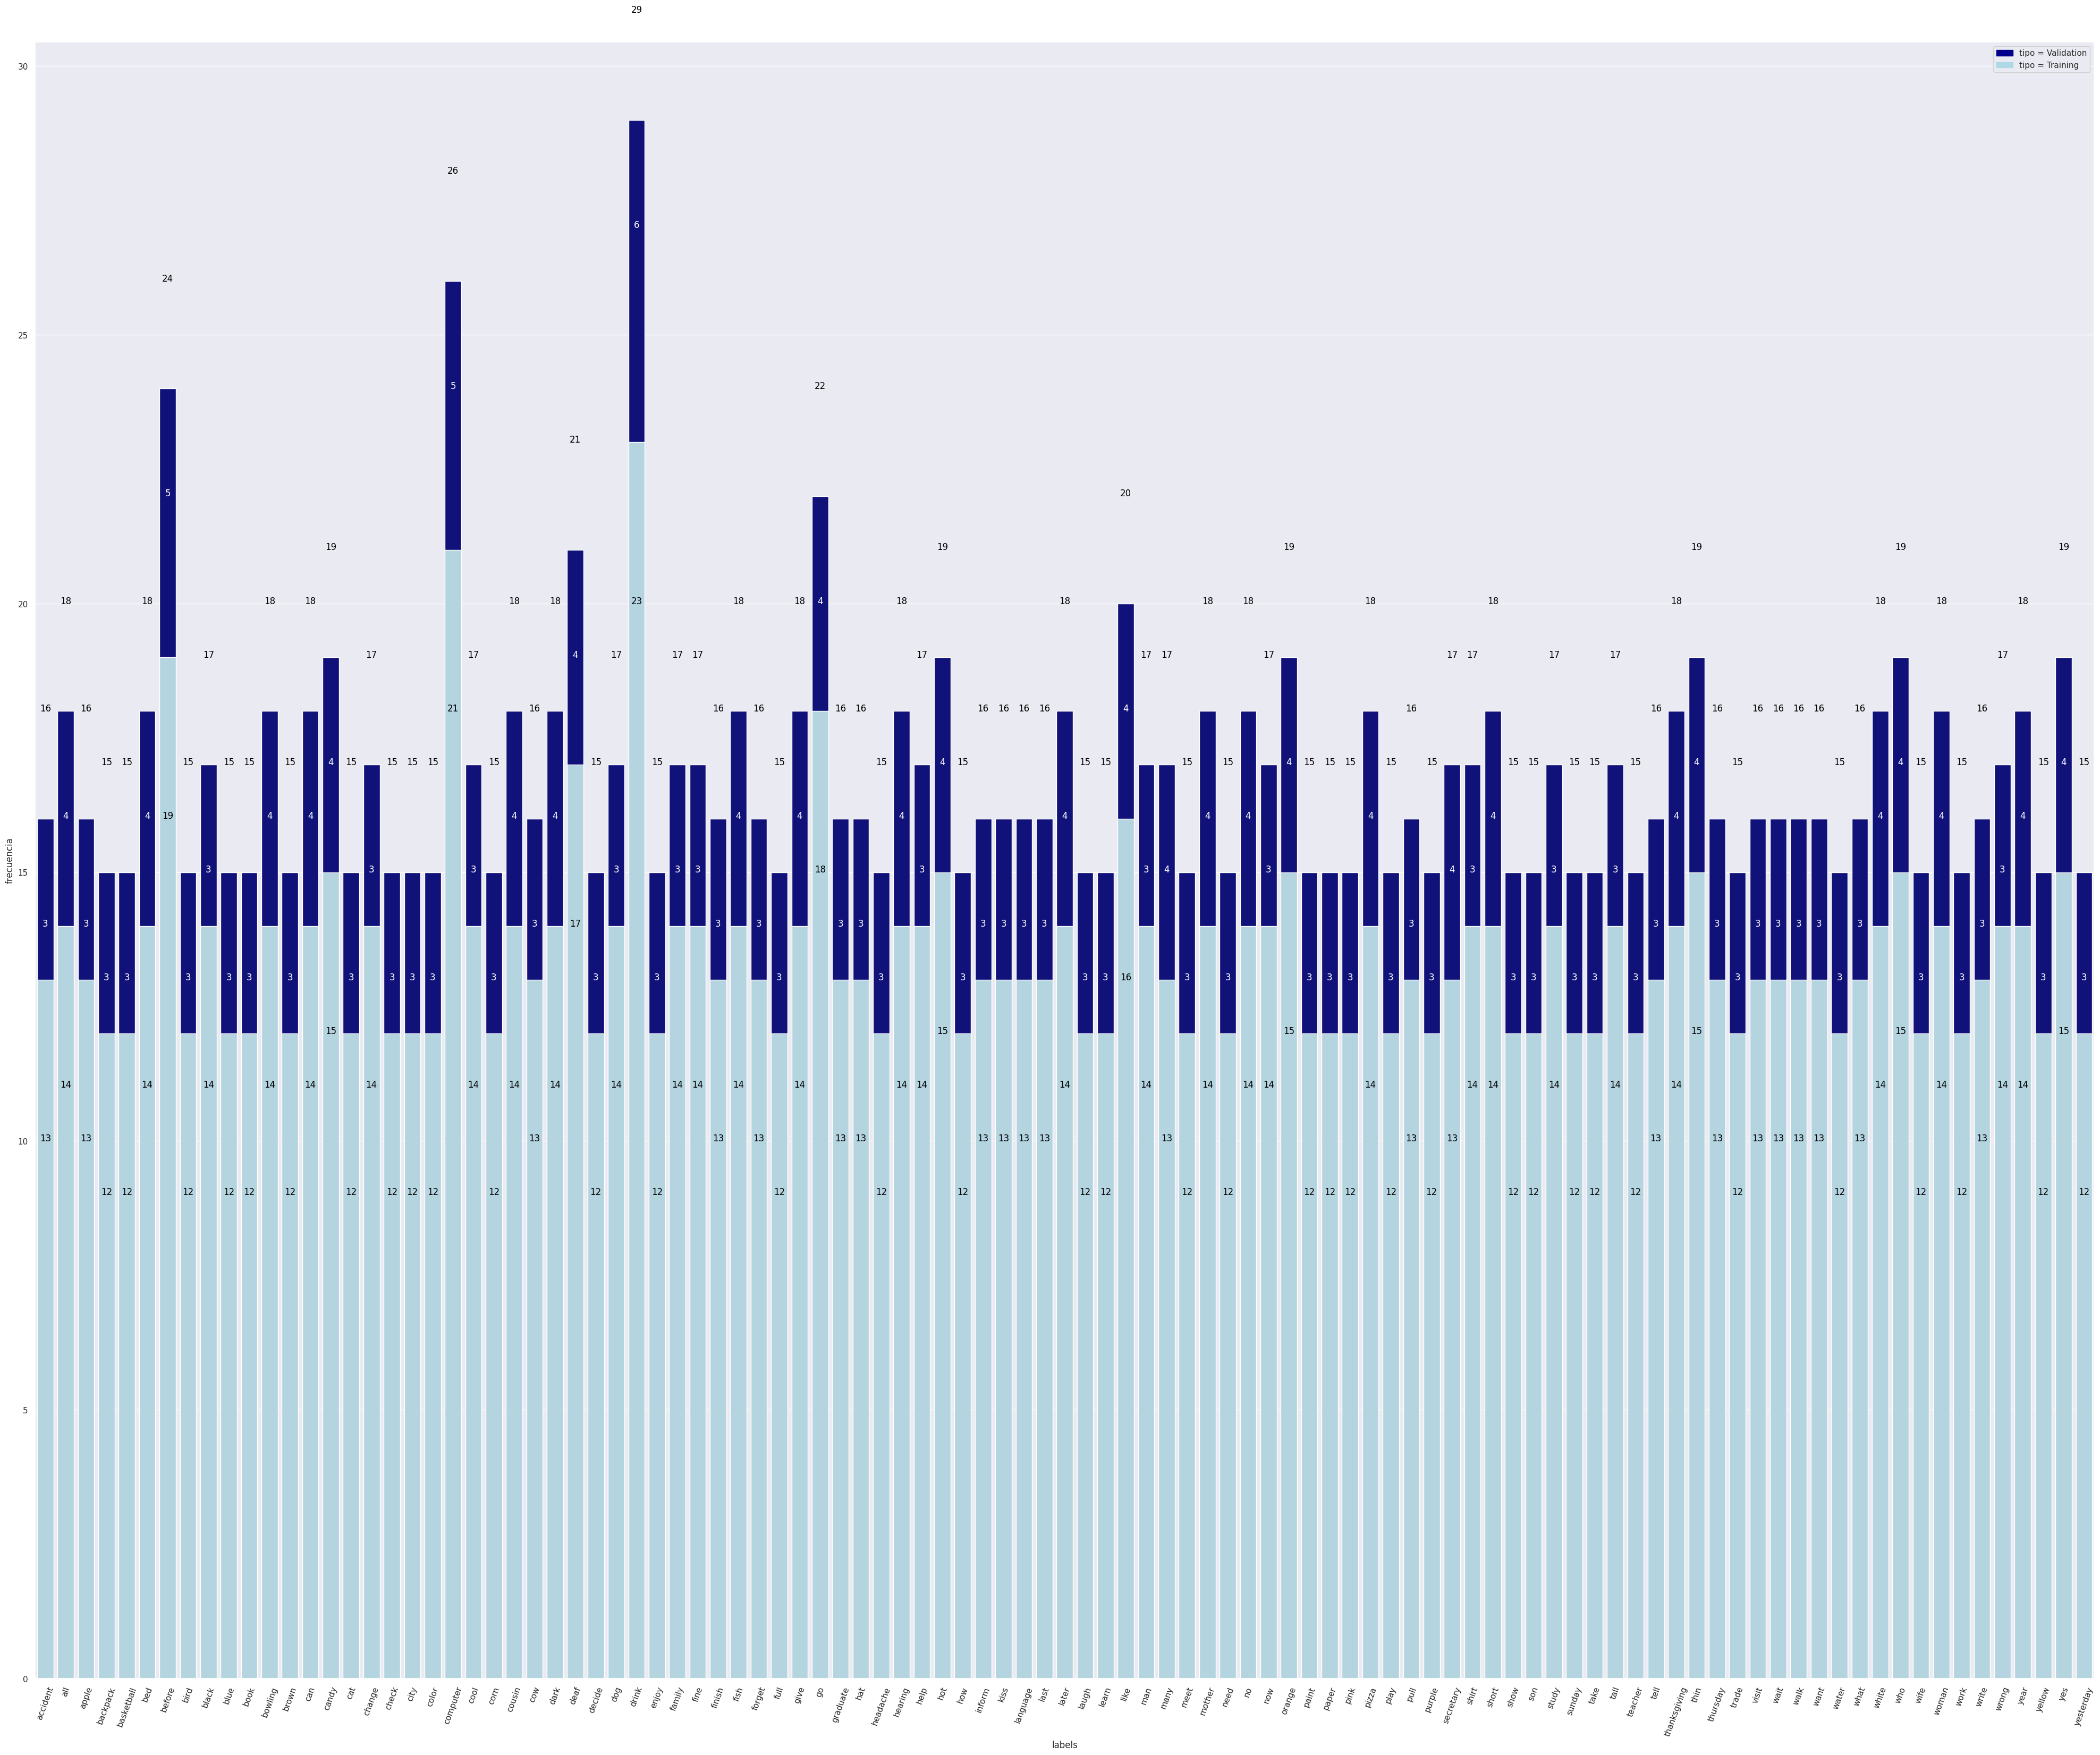

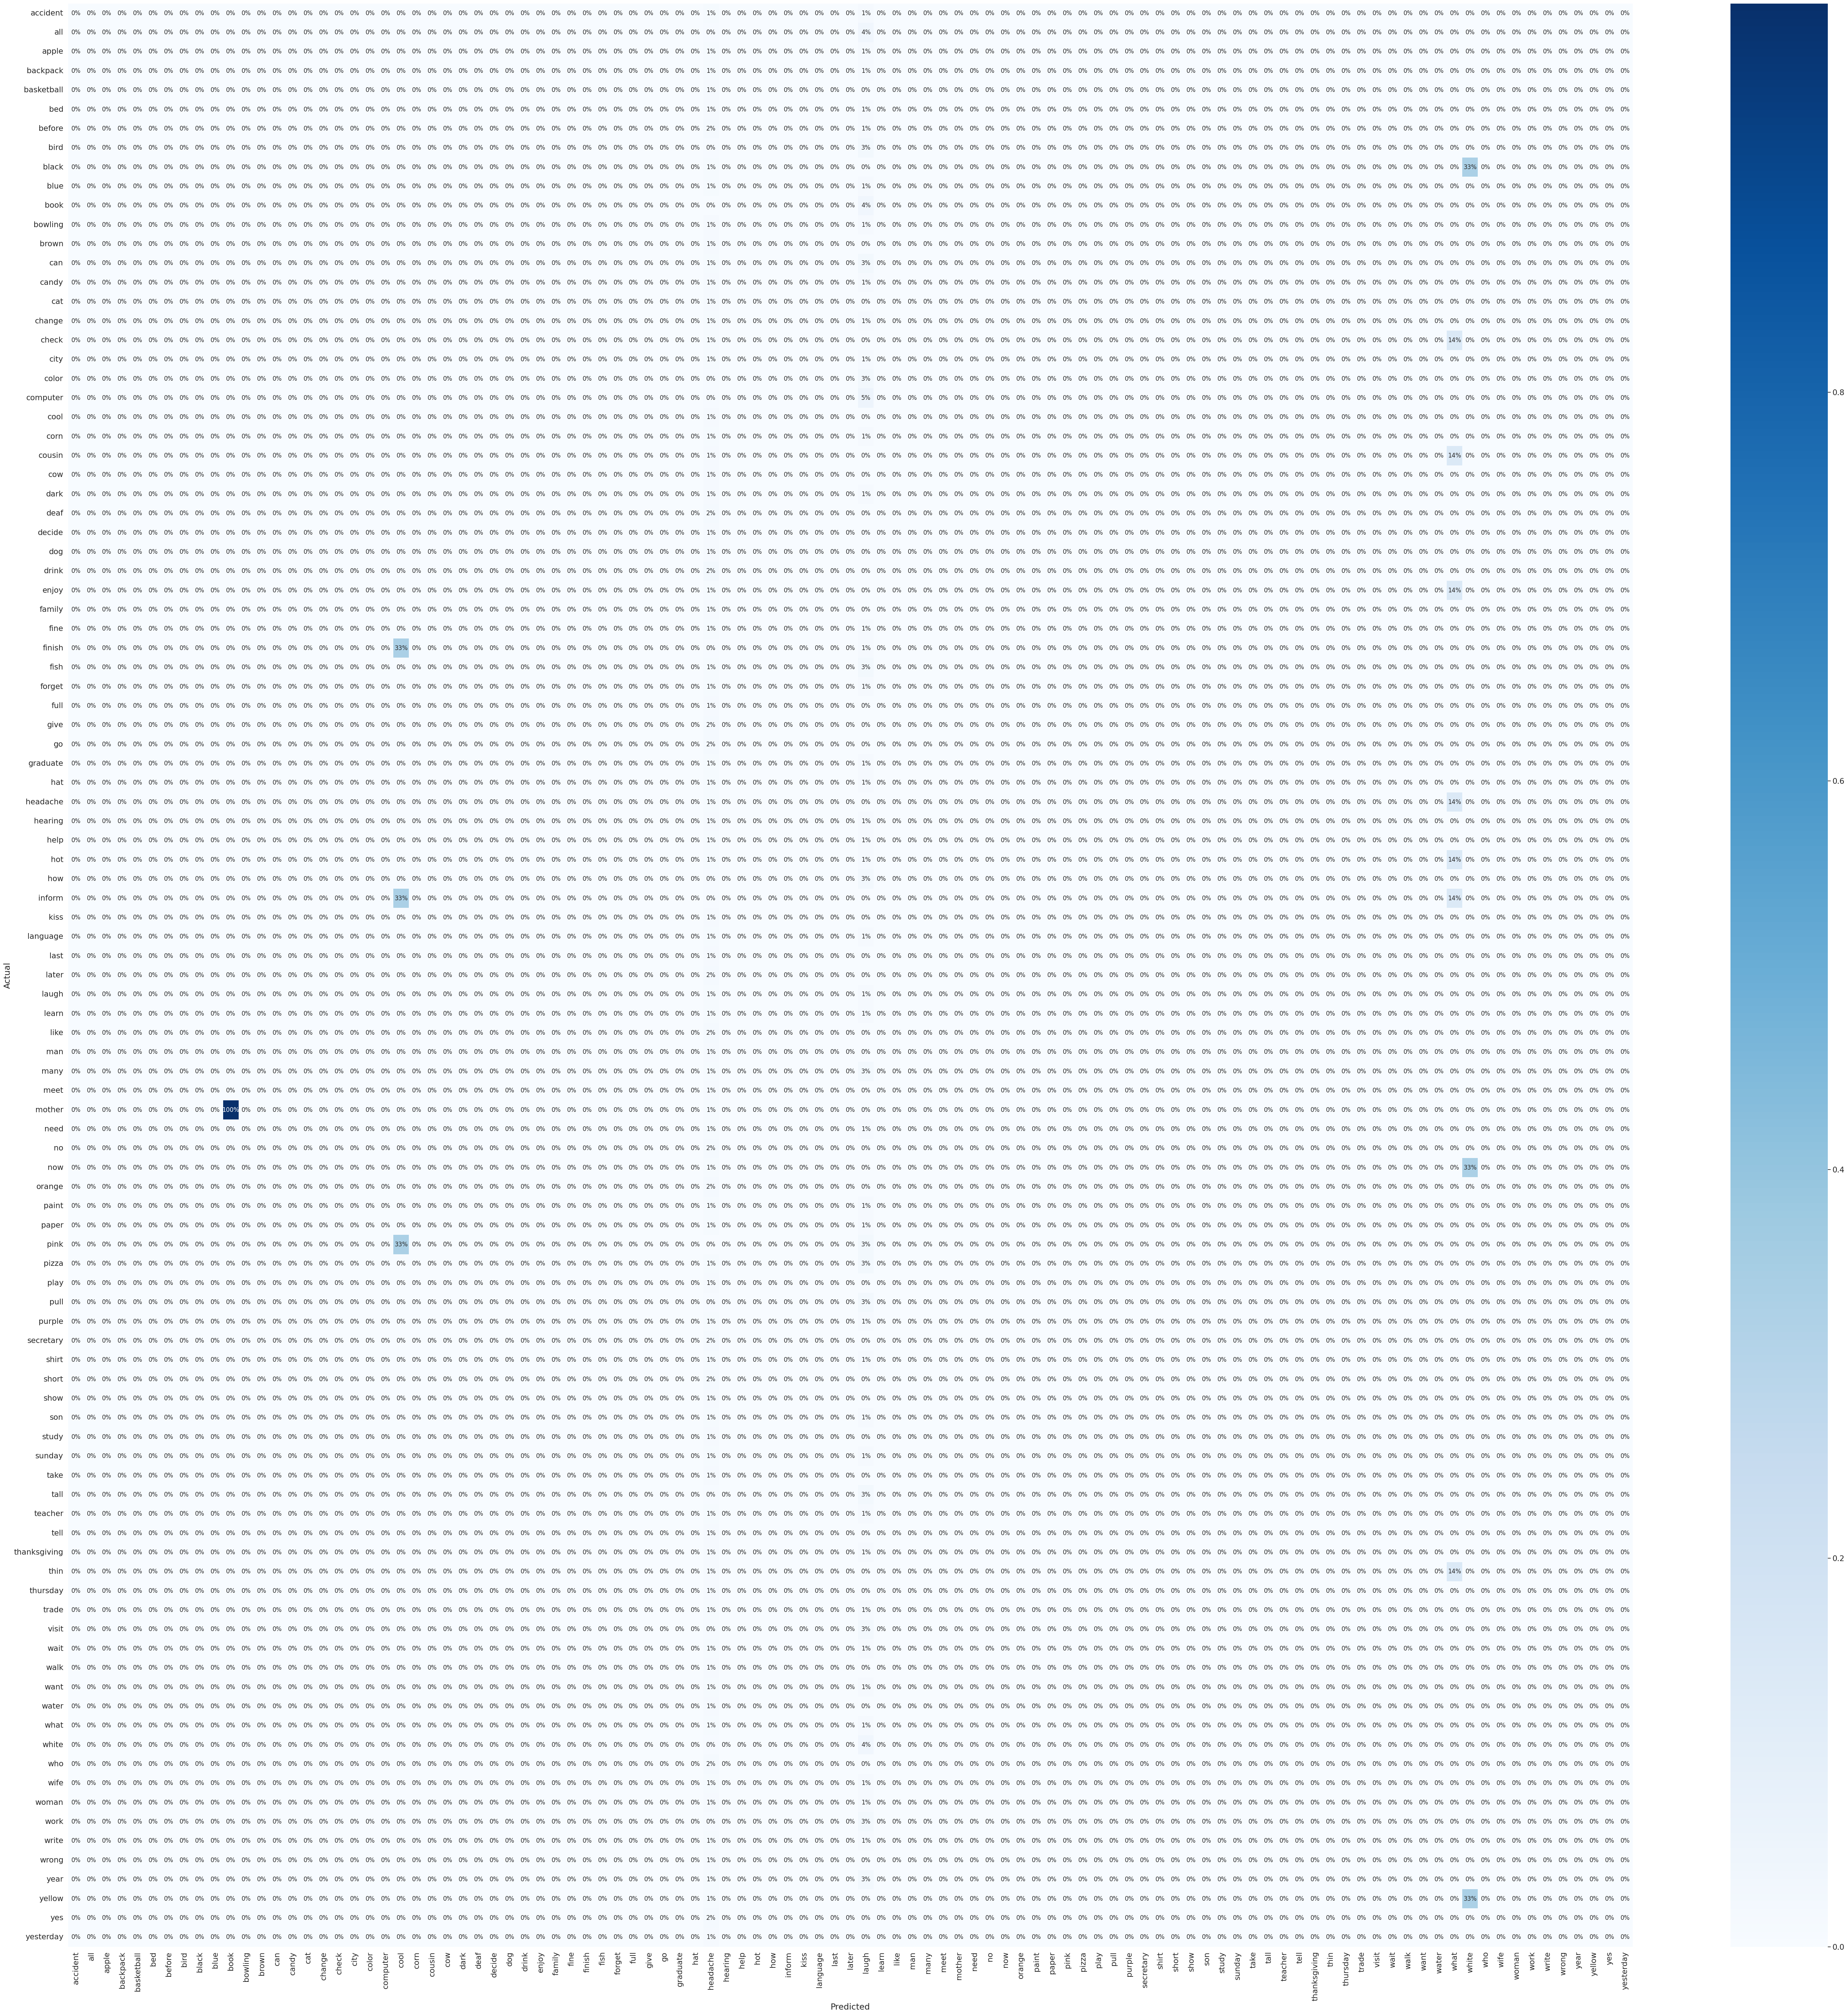

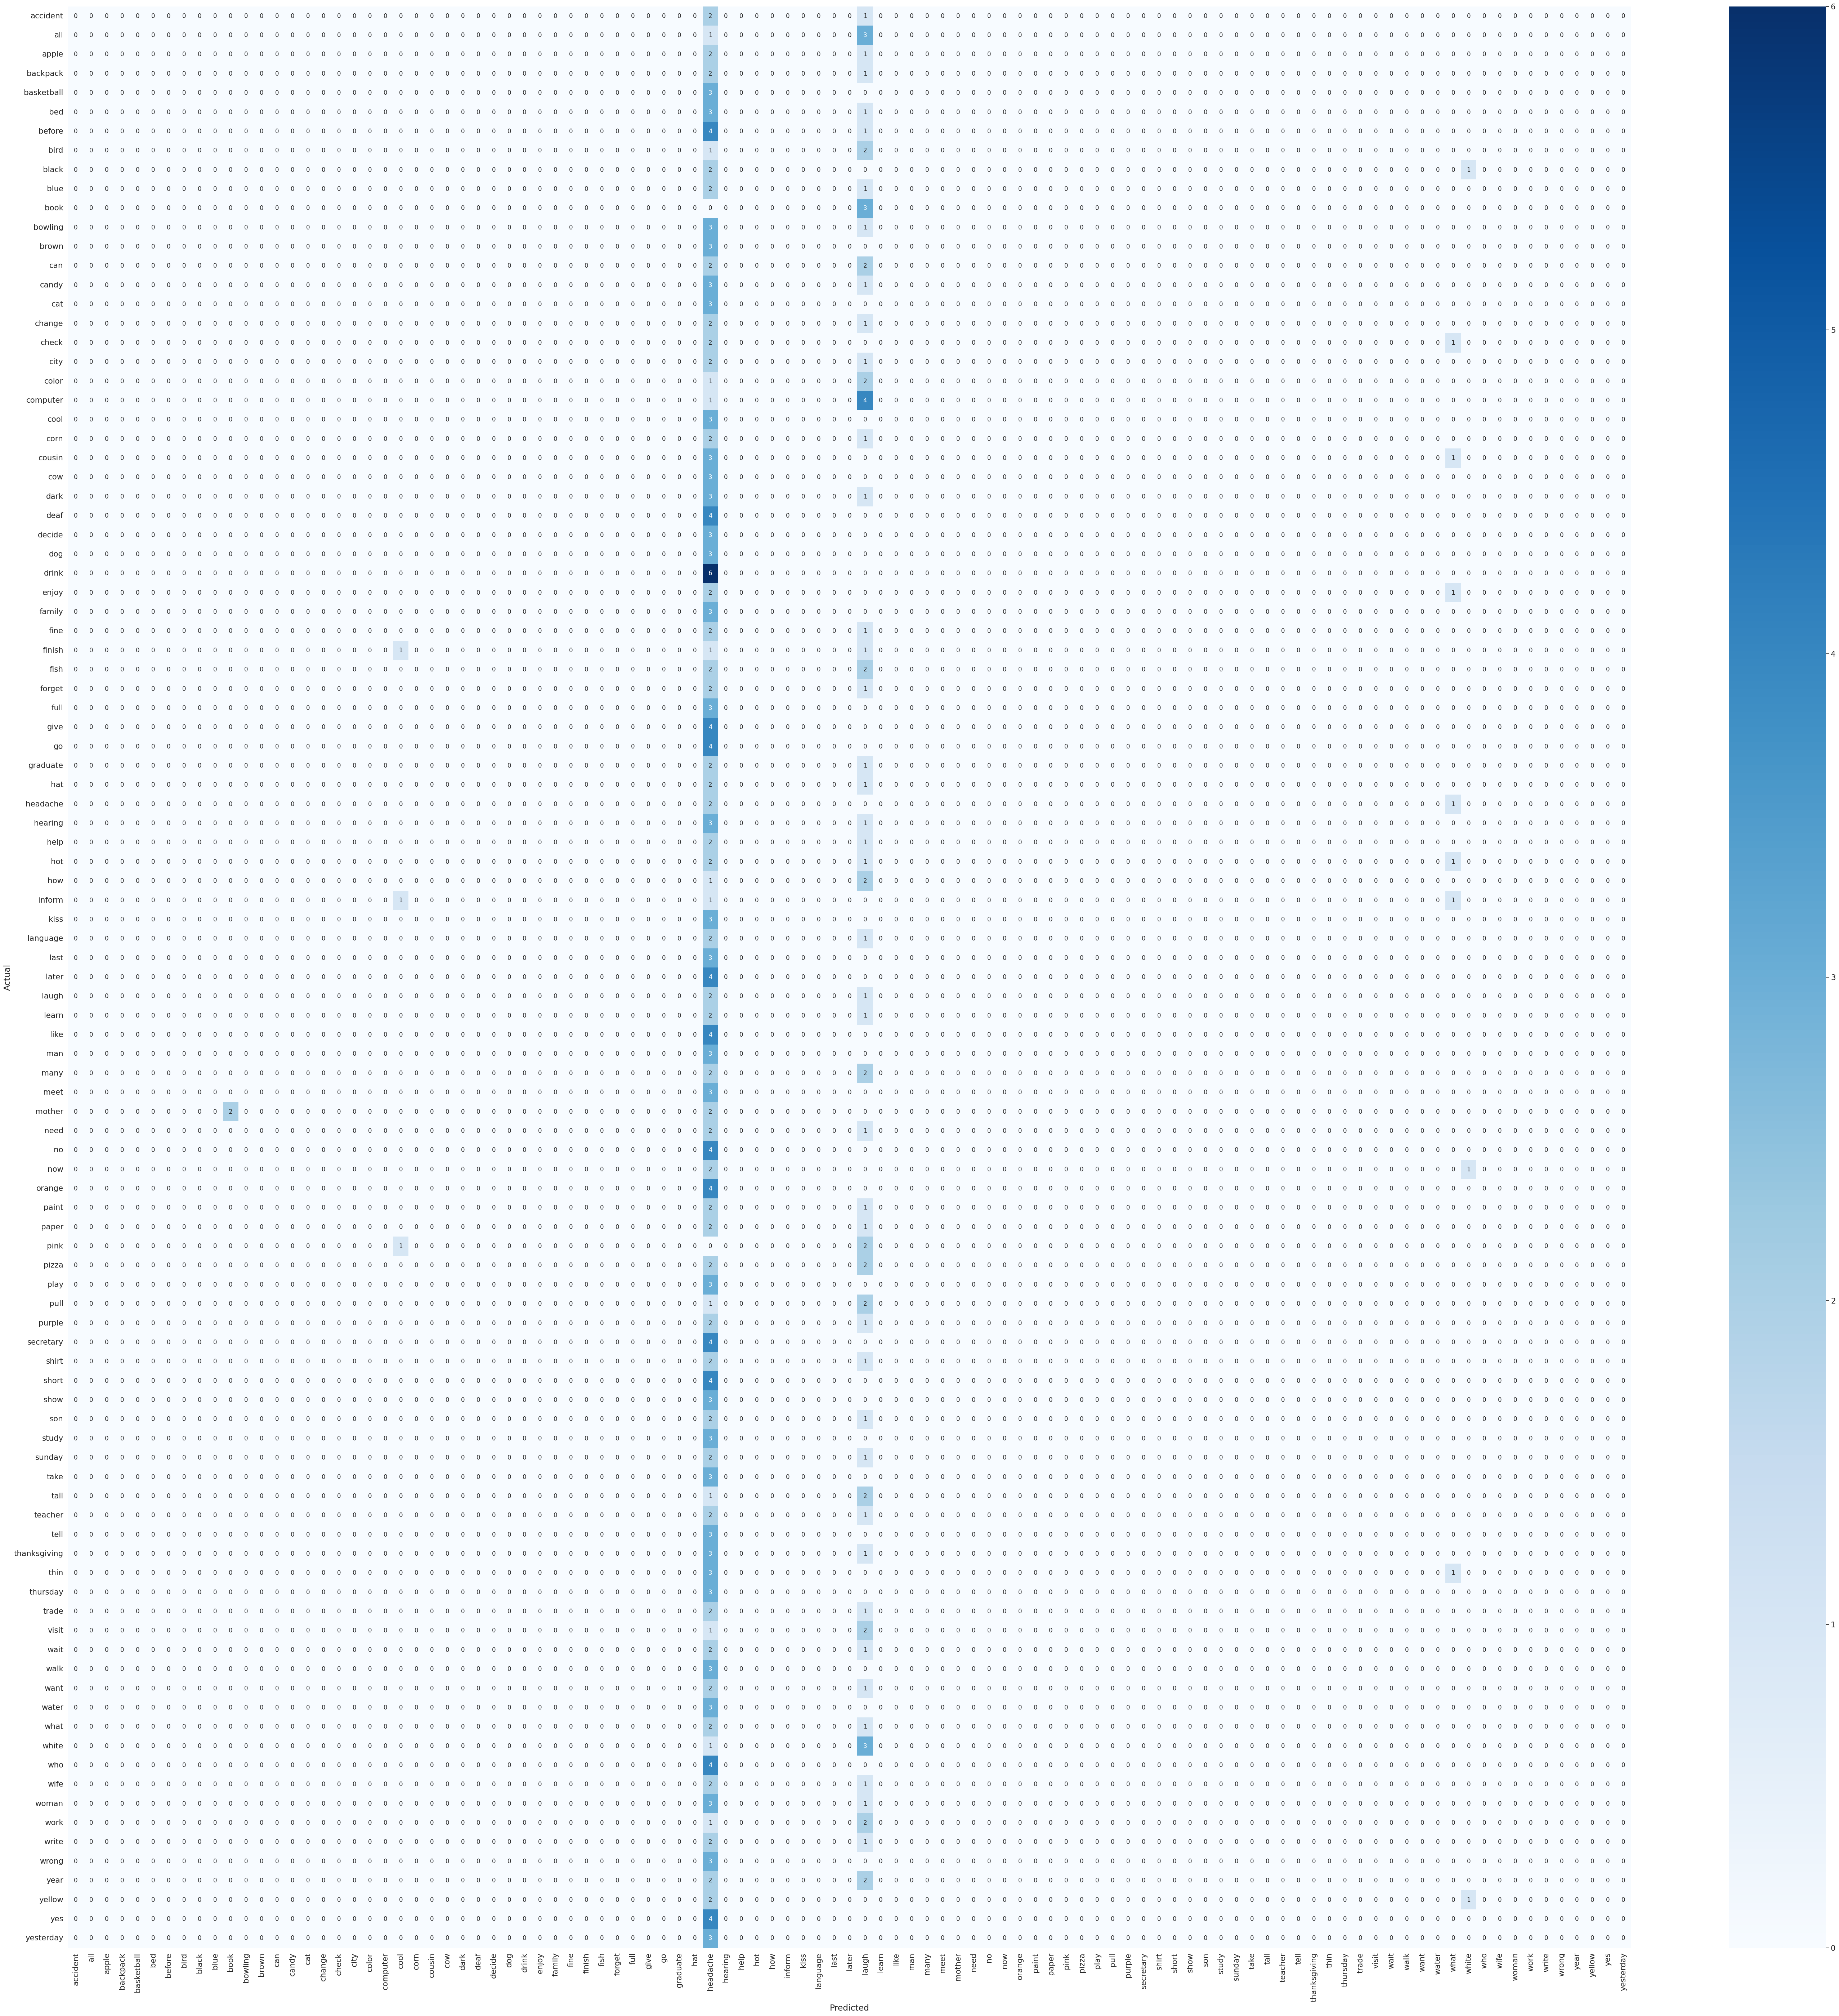

In [61]:
my_evaluate(tested_model,train_set,train_loader,eval_loader,device,args.experiment_name,print_stats=True)

In [13]:
train_true_values = []

for i, data in enumerate(train_loader):
    inputs, labels = data
    true_value = int(labels[0][0])
    true_value = train_set.inv_dict_labels_dataset[true_value]
    train_true_values.append(true_value)

In [14]:
model = tested_model
dataloader = eval_loader 
print_stats = True
pred_correct, pred_all = 0, 0
stats = {i: [0, 0] for i in range(101)}

true_values = []
predicted_values = []
true_values_id = []

predicted_values_proba = []
for i, data in enumerate(dataloader):
    inputs, labels = data
    inputs = inputs.squeeze(0).to(device)
    labels = labels.to(device, dtype=torch.long)

    outputs = model(inputs).expand(1, -1, -1)
    
    predicted_value = int(torch.argmax(torch.nn.functional.softmax(outputs, dim=2)))
    
    predicted_values_proba.append(list(torch.nn.functional.softmax(outputs, dim=2)[0][0].tolist()))
    
    true_value= int(labels[0][0])
    true_values_id.append(true_value)
    true_value2 = train_set.inv_dict_labels_dataset[true_value]
    predicted_value2 = train_set.inv_dict_labels_dataset[predicted_value]
    true_values.append(true_value2)
    predicted_values.append(predicted_value2)
    # Statistics
    if  true_value == predicted_value:
        stats[int(labels[0][0])][0] += 1
        pred_correct += 1

    stats[int(labels[0][0])][1] += 1
    pred_all += 1

if print_stats:
    stats = {key: value[0] / value[1] for key, value in stats.items() if value[1] != 0}
    print("Label accuracies statistics:")
    print(str(stats) + "\n")
    logging.info("Label accuracies statistics:")
    logging.info(str(stats) + "\n")

pred_correct, pred_all, (pred_correct / pred_all)

Label accuracies statistics:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.6666666666666666, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.3333333333333333, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0}



(3, 339, 0.008849557522123894)

In [15]:
torch.nn.functional.softmax(outputs, dim=2)

tensor([[[4.0593e-07, 9.0514e-09, 8.0015e-05, 4.6799e-03, 4.3015e-04,
          8.1393e-07, 1.6893e-08, 4.7153e-05, 1.4216e-05, 1.1812e-06,
          9.5567e-08, 6.9689e-06, 5.0795e-08, 5.0320e-05, 4.2223e-05,
          4.1070e-03, 4.5712e-06, 2.1646e-06, 3.7369e-09, 1.1193e-07,
          2.4031e-08, 9.5724e-06, 7.9451e-05, 5.3076e-07, 1.7108e-03,
          3.2238e-07, 2.5646e-07, 1.0334e-07, 1.3419e-05, 5.8917e-06,
          1.3420e-07, 4.7043e-08, 1.8827e-06, 2.0176e-08, 1.4728e-04,
          4.8281e-05, 2.8943e-07, 7.0902e-07, 7.4508e-06, 1.3149e-08,
          1.2144e-07, 8.3979e-01, 1.5488e-06, 5.3152e-09, 5.6373e-07,
          4.6075e-07, 3.3879e-04, 1.9379e-05, 5.0897e-07, 4.6804e-06,
          1.1952e-05, 1.4706e-01, 4.7114e-05, 1.0785e-07, 1.3663e-05,
          3.4928e-05, 4.5424e-08, 7.0962e-06, 5.0229e-06, 3.2882e-08,
          2.3690e-05, 1.5771e-06, 2.7982e-07, 6.5470e-09, 1.0544e-07,
          8.1190e-06, 7.7121e-04, 1.1184e-06, 1.1028e-05, 6.5114e-09,
          1.5034e-08

In [16]:
labels

tensor([[42]], device='cuda:0')

In [17]:
true_value,predicted_value

(42, 41)

In [18]:
true_values_id[0]

23

In [19]:
predicted_values_proba[0]

[8.069572686508764e-06,
 2.215001131844474e-06,
 0.0014864554395899177,
 0.007787459995597601,
 0.00020062940893694758,
 3.6768672089237953e-06,
 2.813613491525757e-06,
 0.0007355078705586493,
 2.380593286943622e-06,
 2.7547039849196153e-07,
 7.497515639443009e-07,
 5.721684647141956e-05,
 3.925496002921136e-06,
 0.0004823458439204842,
 0.0053078592754900455,
 0.00048254281864501536,
 0.0002170167281292379,
 0.00024200338521040976,
 1.239683466991437e-08,
 3.29004507193531e-07,
 1.8113523481133598e-07,
 3.8009859508747468e-06,
 0.0006876155966892838,
 9.203566975202193e-08,
 0.0015823892317712307,
 7.486376034648856e-07,
 3.9683795876044314e-06,
 3.2785564485493524e-07,
 0.0001906549878185615,
 6.791238320147386e-06,
 2.482261834302335e-06,
 3.9876063340216206e-08,
 0.00019653470371849835,
 3.1303198255727693e-08,
 0.004797833506017923,
 9.227864211425185e-05,
 4.148287916905247e-05,
 3.6580784126272192e-06,
 0.0020317300222814083,
 4.963934316037921e-06,
 1.0392204075060363e-07,
 0.02

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import top_k_accuracy_score

acc_total = accuracy_score(true_values, predicted_values)
acc_total

0.008849557522123894

In [21]:
topk = ''
for k in range(1,6):
    topk +='k ='+str(k)+' top_k_accuracy_score = '+str(top_k_accuracy_score(true_values_id, predicted_values_proba, k=k))+'\n'
print(topk)

k =1 top_k_accuracy_score = 0.008849557522123894
k =2 top_k_accuracy_score = 0.014749262536873156
k =3 top_k_accuracy_score = 0.02359882005899705
k =4 top_k_accuracy_score = 0.035398230088495575
k =5 top_k_accuracy_score = 0.05309734513274336



In [134]:
y_true = np.array([0, 1, 2, 2])
y_score = np.array([[0.5, 0.2, 0.2],  # 0 is in top 2
[0.3, 0.4, 0.2],  # 1 is in top 2
[0.4, 0.2, 0.3],  # 2 is in top 2
[0.7, 0.2, 0.1]]) # 2 isn't in top 2

accuracy_score(y_true, [0,1,1,0]), top_k_accuracy_score(y_true, y_score, k=2)

(0.5, 0.75)

In [135]:
from torchmetrics import Accuracy
target = torch.tensor([0, 1, 2,2])
preds = torch.tensor([[0.5, 0.2, 0.2],  # 0 is in top 2
[0.3, 0.4, 0.2],  # 1 is in top 2
[0.4, 0.2, 0.3],  # 2 is in top 2
[0.7, 0.2, 0.1]])
accuracy = Accuracy(top_k=2)
accuracy(preds, target)

tensor(0.7500)

In [137]:
true_values
from collections import Counter
val_true_values_counter = Counter(true_values)
train_true_values_counter = Counter(train_true_values)


In [138]:
import pandas as pd
import seaborn as sns

In [139]:
distribution_val = pd.DataFrame.from_dict(dict(val_true_values_counter), orient='index',columns=['frecuencia']).reset_index()
distribution_val = distribution_val.rename(columns={'index':'labels'})
distribution_val['tipo']= 'validation'

In [140]:
distribution_val

,labels,frecuencia,tipo
0,cero,6,validation
1,proteína,7,validation
2,comer,14,validation
3,cuánto,9,validation
4,no,6,validation
5,ver,5,validation
6,manejar,3,validation
7,pensar,6,validation
8,decir,4,validation
9,hermano,7,validation


In [141]:
distribution_train = pd.DataFrame.from_dict(dict(train_true_values_counter), orient='index',columns=['frecuencia']).reset_index()
distribution_train = distribution_train.rename(columns={'index':'labels'})

distribution_train['tipo']= 'training'

In [142]:
distribution_total = pd.concat([distribution_train,distribution_val])

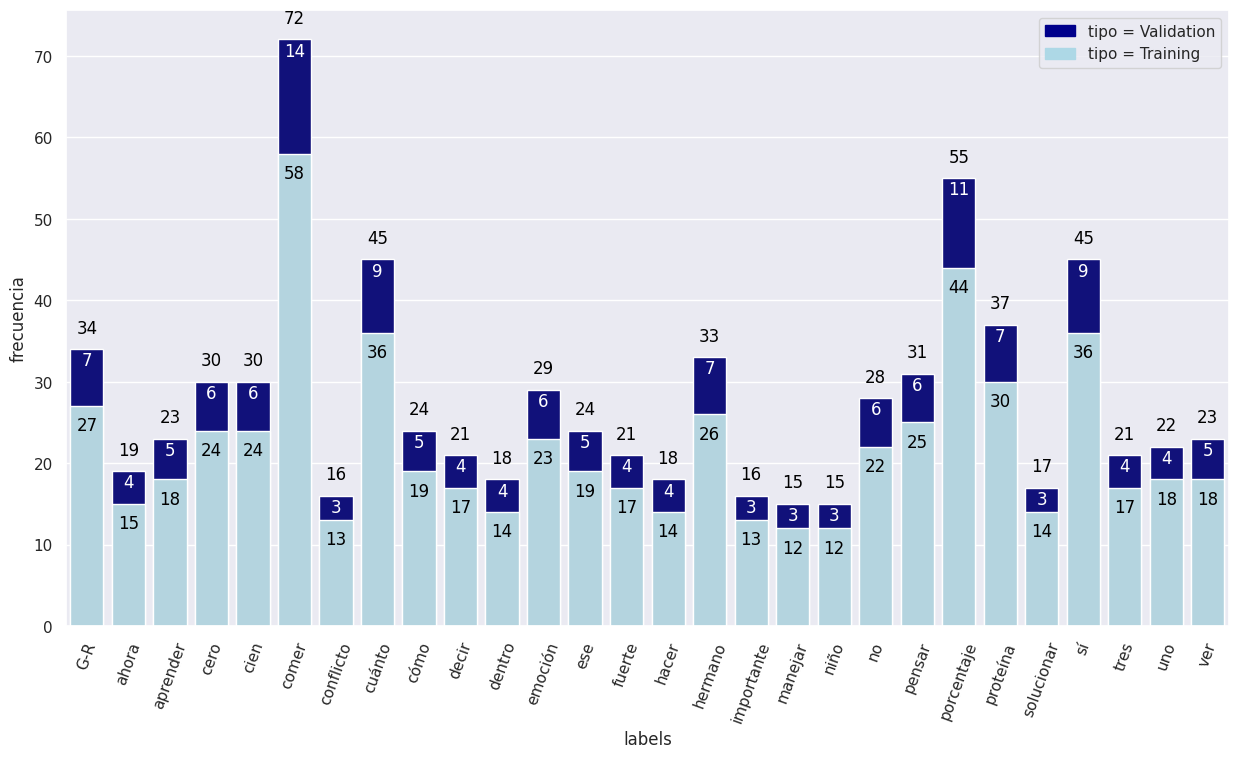

In [144]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(15, 8))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = distribution_total.groupby('labels')['frecuencia'].sum().reset_index()
total = total.sort_values('labels').reset_index()

# bottom bar ->  take only smoker=Yes values from the data
tipo_training = distribution_total[distribution_total.tipo=='training'].reset_index()
tipo_training = tipo_training.sort_values('labels').reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="labels",  y="frecuencia", data=total, color='darkblue')
for index, row in total.iterrows():
    bar1.text(index, row.frecuencia+2, round(row.frecuencia, 2), color='black', ha='center')
    bar1.text(index, row.frecuencia-2, round(row.frecuencia-tipo_training['frecuencia'].iloc[index], 2), color='white', ha='center')
  

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="labels", y="frecuencia", data=tipo_training,  color='lightblue')

for index, row in tipo_training.iterrows():
    bar2.text(index, row.frecuencia-3, round(row.frecuencia, 2), color='black', ha='center')
plt.xticks(rotation=70)

# add legend
top_bar = mpatches.Patch(color='darkblue', label='tipo = Validation')
bottom_bar = mpatches.Patch(color='lightblue', label='tipo = Training')
plt.legend(handles=[top_bar, bottom_bar])
plt.savefig('../out-img/'+args.experiment_name+'_distribution_labels.png', dpi=100)

# show the graph
plt.show()

In [145]:
row.labels

'ver'

In [146]:
train_true_values_unique = list(set(train_true_values))

In [147]:
print(train_true_values_unique)

['fuerte', 'tres', 'G-R', 'sí', 'manejar', 'hacer', 'emoción', 'no', 'cero', 'pensar', 'niño', 'proteína', 'conflicto', 'cómo', 'cuánto', 'cien', 'dentro', 'solucionar', 'importante', 'decir', 'comer', 'ver', 'ahora', 'ese', 'hermano', 'porcentaje', 'aprender', 'uno']


In [148]:
len(train_true_values_unique)

28

In [ ]:
result_classification_report = classification_report(true_values, predicted_values,zero_division=0)

In [149]:
with open('../out-img/'+args.experiment_name+'_classification_report.txt', 'w') as f:
    
    f.write('*'*20)
    f.write('\n')    
    f.write('unique values :')
    f.write('\n')    
    f.write(str(train_true_values_unique))
    f.write('\n')    
    f.write('*'*20)
    f.write('\n')
    f.write('Train dataset counter :')
    f.write('\n')
    f.write(str(train_true_values_counter))
    f.write('\n')
    f.write('*'*20)
    f.write('\n')
    f.write('Validation dataset counter :')
    f.write('\n')
    f.write(str(val_true_values_counter))
    f.write('\n')
    f.write('*'*20)
    f.write('\n')
    f.write('accuracy score total = '+str(acc_total))
    f.write('\n')
    f.write('top_k_accuracy_score')
    f.write('\n')
    f.write(topk)
    f.write('\n')    
    
    f.write(result_classification_report)


In [150]:
print(classification_report(true_values, predicted_values,zero_division=0))

              precision    recall  f1-score   support

         G-R       0.00      0.00      0.00         7
       ahora       0.00      0.00      0.00         4
    aprender       0.00      0.00      0.00         5
        cero       0.00      0.00      0.00         6
        cien       0.00      0.00      0.00         6
       comer       0.00      0.00      0.00        14
   conflicto       0.00      0.00      0.00         3
      cuánto       0.00      0.00      0.00         9
        cómo       0.00      0.00      0.00         5
       decir       0.00      0.00      0.00         4
      dentro       0.00      0.00      0.00         4
     emoción       0.00      0.00      0.00         6
         ese       0.00      0.00      0.00         5
      fuerte       0.00      0.00      0.00         4
       hacer       0.00      0.00      0.00         4
     hermano       0.00      0.00      0.00         7
  importante       0.00      0.00      0.00         3
     manejar       0.00    

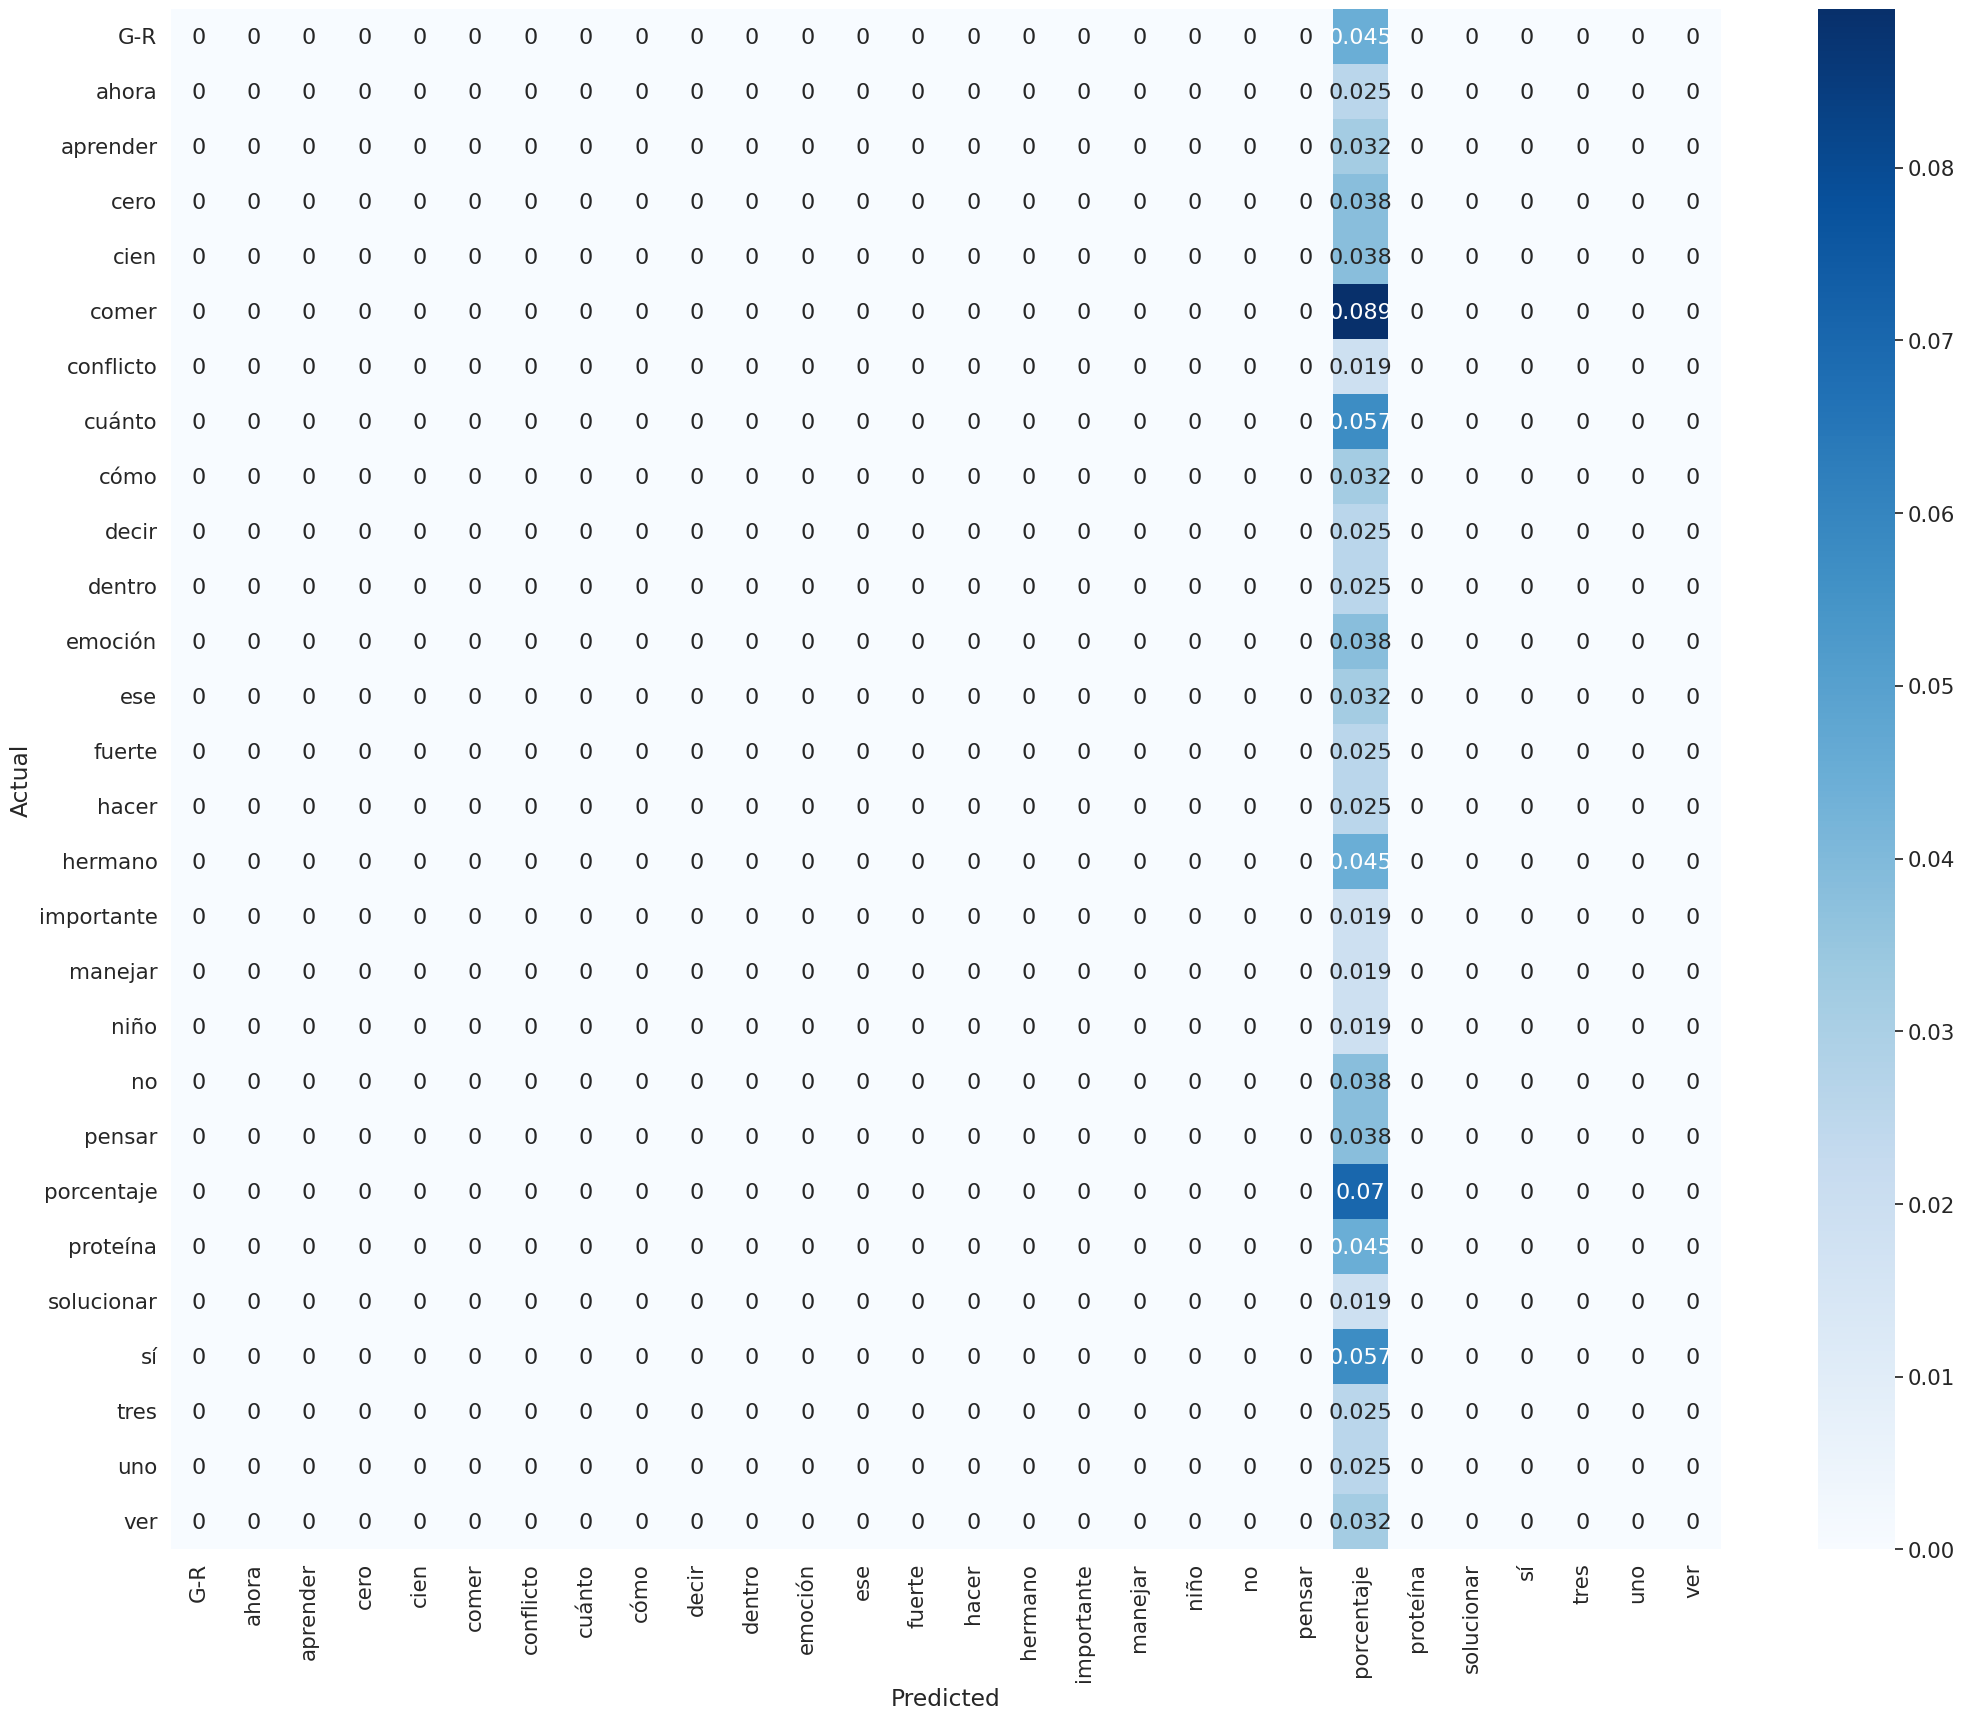

In [151]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = confusion_matrix(true_values, predicted_values)

cm_sum = np.sum(data, axis=0, keepdims=True)
data = data / (cm_sum.astype(float)+0.0001)

df_cm = pd.DataFrame(data, columns=np.unique(true_values), index = np.unique(true_values))

    
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2g')# font size
plt.savefig('../out-img/'+args.experiment_name+'_confusion_matrix_norm.png', dpi=100)


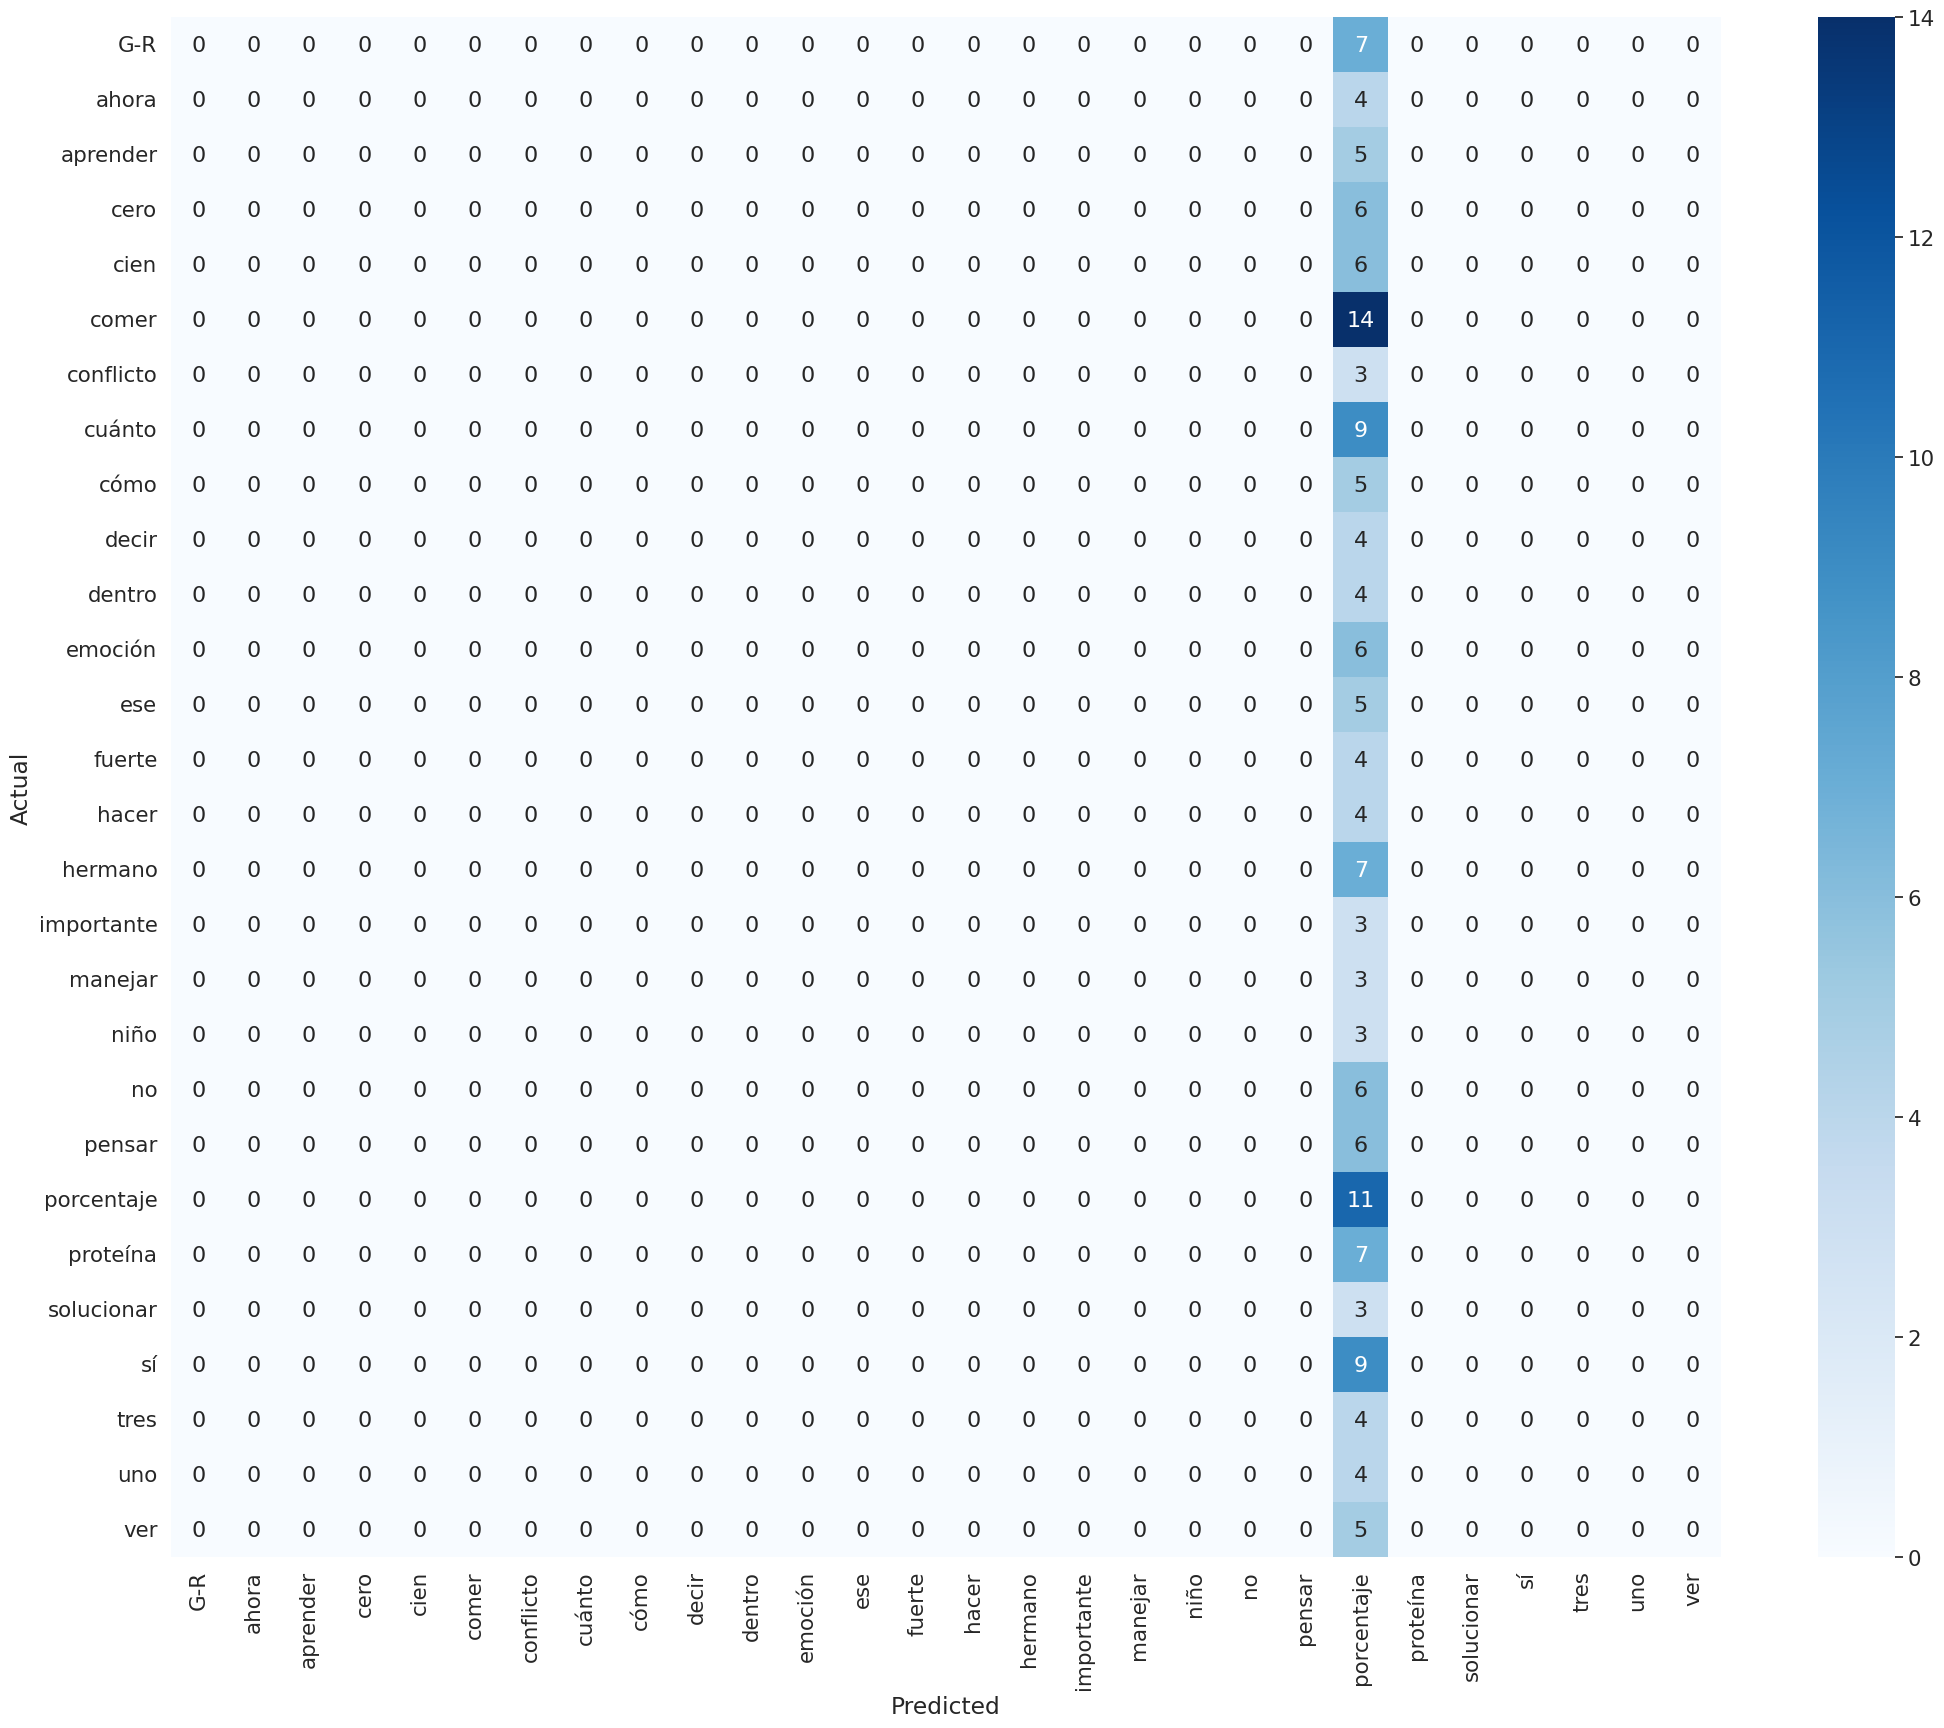

In [152]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = confusion_matrix(true_values, predicted_values)

cm_sum = np.sum(data, axis=0, keepdims=True)
#data = data / (cm_sum.astype(float)+0.0001)

df_cm = pd.DataFrame(data, columns=np.unique(true_values), index = np.unique(true_values))

    
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2g')# font size
plt.savefig('../out-img/'+args.experiment_name+'_confusion_matrix.png', dpi=100)
